In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import glob

from torch.utils import data
from PIL import Image
from torchvision import transforms
from torch import nn

In [2]:
class MyDataset(data.Dataset): # 自定义类
    def __init__(self, img_paths, img_labels, transform):
        self.imgs = img_paths # 获取图片路径
        self.img_labels = img_labels # 获取标签
        self.transforms = transform

    def __getitem__(self, index):
        img = self.imgs[index] # 切片
        label = self.img_labels[index] # 切片
        
        pil_img = Image.open(img) # python处理
        pil_img = pil_img.convert("RGB")   # 可选,建议都使用
        data = self.transforms(pil_img)

        return data, label

    def __len__(self):
        return len(self.imgs) # 总数

In [3]:
img_paths = glob.glob('../datasets/birds/*/*.jpg')

In [4]:
print(img_paths[100])

print(img_paths[100].split('/')[3].split('.')[1])

../datasets/birds/136.Barn_Swallow/Barn_Swallow_0026_132386.jpg
Barn_Swallow


In [5]:
img_labels = [img_path.split('/')[3].split('.')[1] for img_path in img_paths]

lable_to_index = dict((v, k) for k, v in enumerate(np.unique(img_labels)))
index_to_lable = {v: k for k, v in lable_to_index.items()}


order = np.random.permutation(len(img_paths)) # 随机打乱
img_slice = int(len(img_paths)*0.8) # 切出80%训练

# 训练数据
train_imgs = img_paths[:img_slice]
train_labels = img_labels[:img_slice]
# 测试数据
test_imgs = img_paths[img_slice:]
test_labels = img_labels[img_slice:]

# 格式转换
transform = transforms.Compose([
                transforms.Resize((224, 224)), # 统一大小
                transforms.ToTensor(), # 规范格式
])

train_ds = MyDataset(train_imgs, train_labels, transform)
test_ds = MyDataset(test_imgs, test_labels, transform)

batch_size = 64
train_dl = data.DataLoader(train_ds, batch_size)
test_dl = data.DataLoader(test_ds, batch_size)

imgs_batch, labels_batch = next(iter(train_dl))


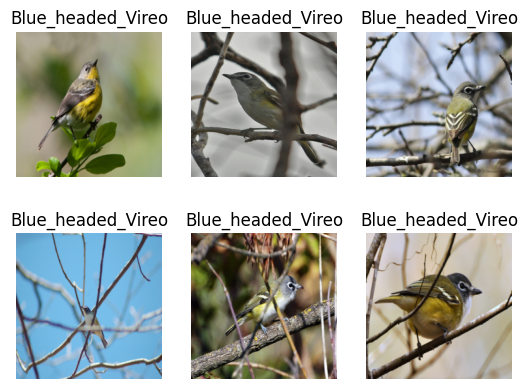

In [6]:

for i, (img,lable) in enumerate(zip(imgs_batch[:6],labels_batch[:6])):
    img = img.permute(1, 2, 0)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(lable)    
    plt.axis('off')

In [7]:
model = torchvision.models.densenet121(pretrained = True).features

/home/cyh/anaconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cyh/anaconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model.cuda()

for param in model.parameters():
    param.requires_grad = False

#### 提取特征

In [9]:
train_features = []
train_features_labels = []

for img,label in train_dl:
    pre = model(img.cuda())
    # pre.size(0) 批次
    pre = pre.view(pre.size(0),-1)
    train_features.append(pre.data)
    train_features_labels.append(label)
    
test_features = []
test_features_labels = []

for img,label in test_dl:
    pre = model(img.cuda())
    pre = pre.view(pre.size(0),-1)
    test_features.append(pre.data)
    test_features_labels.append(label)

#### 特征预处理

In [10]:
class FeaturesDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

train_ds = FeaturesDataset(train_features, train_features_labels)
test_ds = FeaturesDataset(test_features, test_features_labels)

train_dl = data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = data.DataLoader(test_ds, batch_size=64)

In [11]:
# class modelFC(nn.Module):
#     def __init__(self,in_size,out_size) -> None:
#         super().__init__()
#         self.fc = nn.Sequential(
            
#         )

modelFC = nn.Linear(train_features[0].shape[0], len(lable_to_index)).cuda()

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(modelFC.parameters(), lr= 0.00001)


In [12]:
# 训练函数
def train(dl, model, loss_fn, optimizer):
    model.train() # 训练模式
    size = len(dl.dataset) # 总的个数    
    num_batches = len(dl) # 总批次数 = 总的个数//每批数
        
    train_loss, correct = 0, 0
        
    for x, y in dl:
        y = torch.tensor(y, dtype=torch.long)
        x, y = x.to('cuda'), y.to('cuda')
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # pred 第一维是每批数 
            correct += (pred.argmax(1) == y).float().sum().item()
            train_loss += loss.item()
    # lr.step() # 使用学习速率衰减 
    correct /= size
    train_loss /= num_batches
    
    return correct, train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    model.eval() # 预测模式 
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in test_dl:
            y = torch.tensor(y, dtype=torch.long)
            x, y = x.to('cuda'), y.to('cuda')
            pred = model(x)         
            loss = loss_fn(pred, y)
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).float().sum().item()
        correct /= size
        test_loss /= num_batches
        return correct, test_loss
    
def fit(epochs,train_dl,test_dl,model, loss_fn, opt):
    # 列表记录每轮的数据
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
        
        # 追加到列表中
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
                 
        # 打印模板
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
        
        print(template.format(epoch, epoch_train_loss, epoch_train_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    
    return train_loss,train_acc,test_loss,test_acc

In [13]:
epochs = 50
(train_loss,
 train_acc,
 test_loss,
 test_acc) = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=modelFC, loss_fn=loss_fn, opt=opt)

plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend()


RuntimeError: stack expects each tensor to be equal size, but got [64, 50176] at entry 0 and [22, 50176] at entry 16